In [1]:
import json
import os
from langdetect import detect as detectlang, DetectorFactory
DetectorFactory.seed = 0
#from textblob import TextBlob
import pandas as pd
import seaborn as  sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
import re
%matplotlib inline
import warnings; warnings.simplefilter('ignore')


In [2]:
#Get HT Counts (REGEX TO DO)

def UpdateHasttagDict(htlist, hashtags):
    curr_doc_counts = {}
    for t in htlist:
        tlower = t.lower()
        curr_doc_counts[tlower] = curr_doc_counts.get(tlower,0)+1
    
    for ht,doccnt in curr_doc_counts.items():
        if ht in hashtags:
            hashtags[ht]['tf'] +=doccnt
            hashtags[ht]['df'] +=1            
        else:
            hashtags[ht] = {'tf' :doccnt , 'df': 1}
    return hashtags
    
   
def ExtractHashTags(text):
    pass
    


In [3]:
def ExtractInfo(tjson, hashtags):
    tweet_text = tjson['full_text'].replace('\n','').strip()
    
    #Extract HTS from JSON
    htjsonlist = [ht['text'] for ht in tjson['entities']['hashtags']]
    
    #Extract HTS from Based on regex    
    #hashtags = ExtractHashTags(text)
   
    hashtags = UpdateHasttagDict(htjsonlist, hashtags)
    
    
    return hashtags
    #htagsincurrtweet = ExtractHashTags(tweet_text)
    
    

In [4]:
def Dicttodataframe(dictin, idxname, columnsin = None):
    df =pd.DataFrame.from_dict(dictin, orient='index')
    if columnsin:
        df.columns = columnsin
    df.index.name = idxname
    df= df.reset_index()
    return df


In [5]:
def ResolveLanguage(shortname, langconfig):
    for l in langconfig:
        if shortname==l['code']:
            return l['name']
    return shortname
    

In [6]:
datafolder ='Data/'
jsonfolder='/JSON/'
hashtagsdict  = {}
langdict = {}
langdictJSON = {}
langconfig = None
with open('langconfig.json', 'r') as f:
    langconfig = json.load(f)
    
orig_htlist = ['service', 'price', 'cost', 'quality', 'ambiente', 'reservation']


tweetjsonfiles = os.listdir(datafolder + jsonfolder)
for tweetfile in tweetjsonfiles:
    currjson = json.loads(open(datafolder + jsonfolder + tweetfile).read())    
    hashtagsdict = ExtractInfo(currjson, hashtagsdict)
    #lang= TextBlob(currjson['full_text']).detect_language()
    
    
    lang =  ResolveLanguage(detectlang(currjson['full_text']), langconfig)
    langdict[lang] = langdict.get(lang,0) +1
    
    langjson = ResolveLanguage(currjson['lang'],langconfig)
    langdictJSON[langjson] = langdictJSON.get(langjson,0) +1
    
    
    

#print(detected_lang, currjson['lang'])
# for ht, val in hashtags.items():
#     print(ht, val['tf'], val['df'])

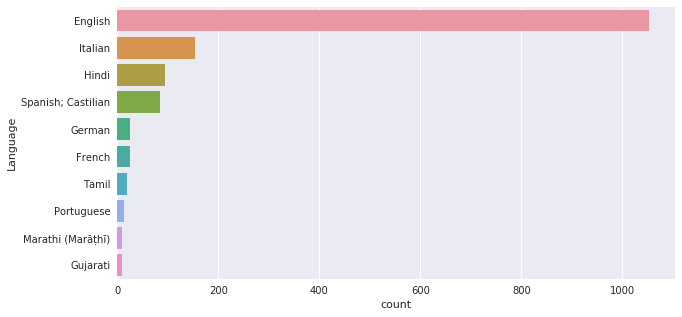

In [7]:
#See Language Distribution (Detected)
langdf = Dicttodataframe(langdict, 'Language',['count'])
top10languages = langdf.sort_values(by="count", ascending=False).iloc[0:10]
plt.figure(figsize=(10,5))
ax = sns.barplot("count", "Language", data=top10languages, orient="h" )#.set_title("Top 10 detected languages based on their document frequency")
#ax = top10languages.plot.barh(y ='count', x='Language', figsize=(15,10), sort_columns = False)
                              





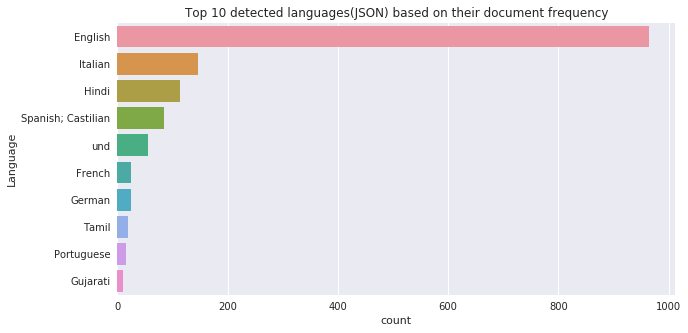

In [8]:
#See Language Distribution (From JSON)
langdfJSON = Dicttodataframe(langdictJSON, 'Language',['count'])
top10languagesJSON = langdfJSON.sort_values(by="count", ascending=False).iloc[0:10]
plt.figure(figsize=(10,5))
ax= sns.barplot("count", "Language", data=top10languagesJSON, orient="h").set_title("Top 10 detected languages(JSON) based on their document frequency")


In [9]:
#Get top 50 words in a dataframe
htdf = Dicttodataframe(hashtagsdict, 'word')
ignore_filter = ~htdf['word'].isin(orig_htlist)
top50 = htdf[ignore_filter].sort_values(by="df", ascending=False).iloc[0:50]


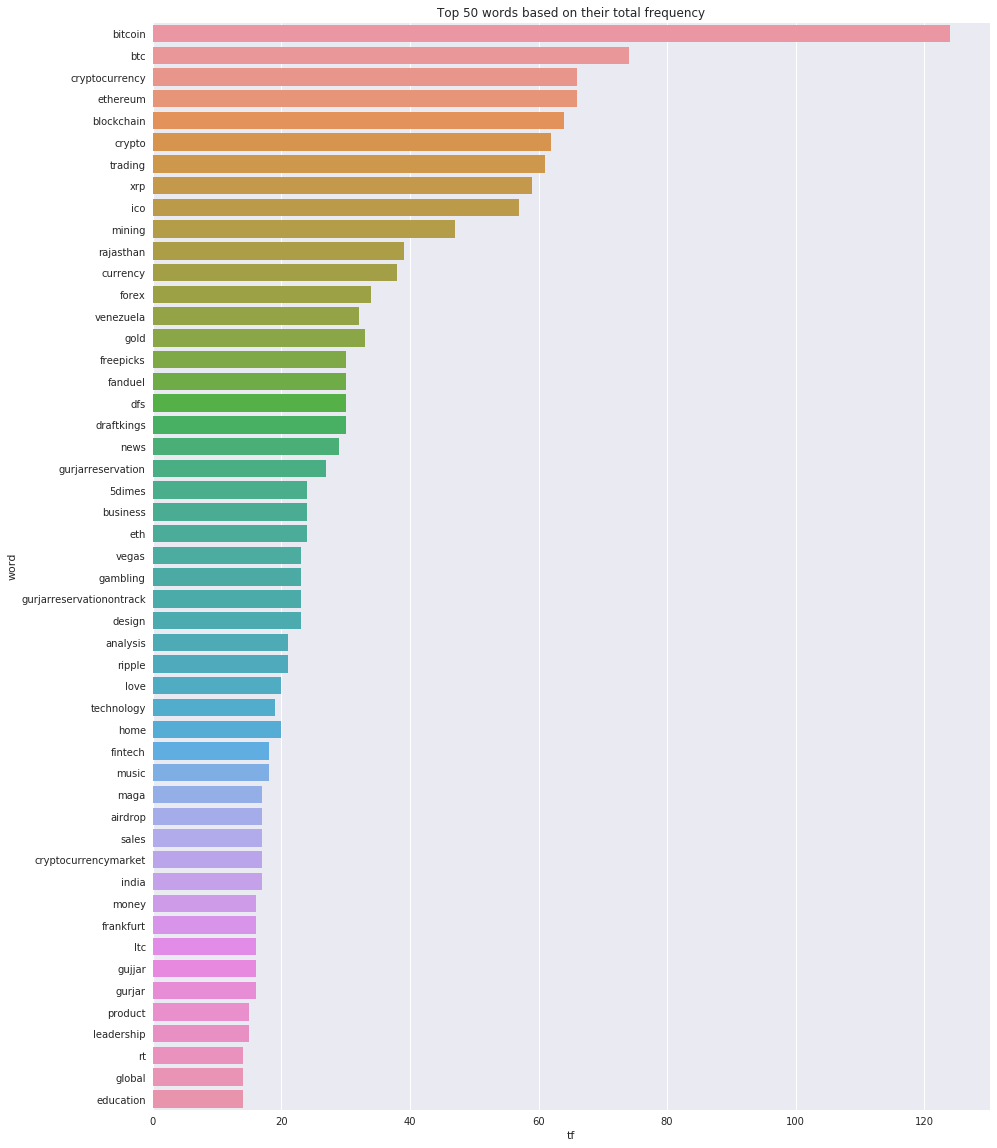

In [10]:
#Plot top 50 frequencies based on total frequency
plt.figure(figsize=(15,20))
ax = sns.barplot("tf", "word", data=top50, orient="h").set_title("Top 50 words based on their total frequency")


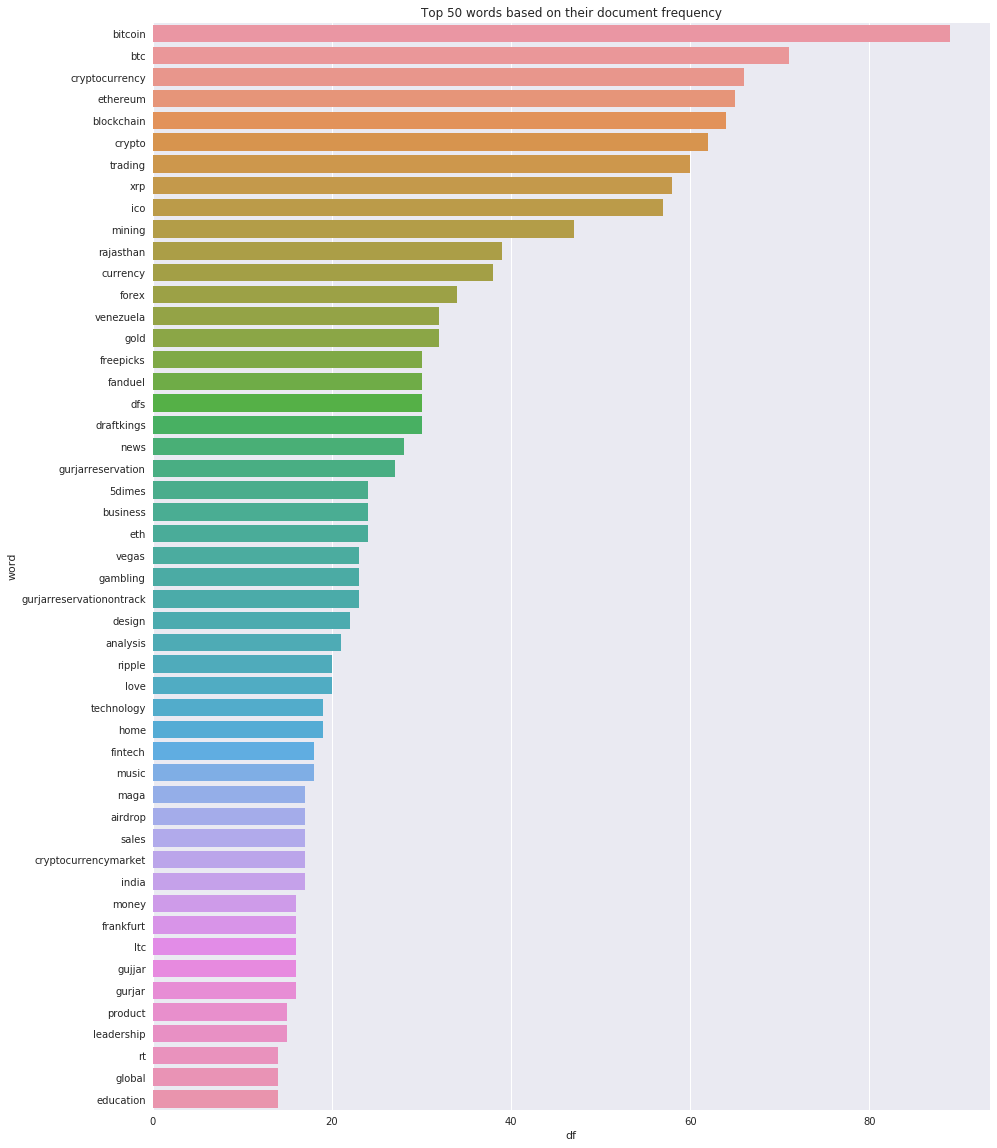

In [11]:
#Plot top 50 frequencies based on document frequency
plt.figure(figsize=(15,20))
ax = sns.barplot("df", "word", data=top50, orient="h").set_title("Top 50 words based on their document frequency")

In [12]:
#get tag networks if time permits